In [11]:

import timeit
import scanpy as sc
import anndata as ad
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import warnings
from copy import deepcopy
import timeit
from random import choice
import time

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from itertools import cycle, islice

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# distance calculator

def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)


## outline

1. Generation of different datasets
  1. Noisy circles
  1. noisy moons
  1. no structure
  1. blobs
1. Kmeans Algorithm implementation
1. Kmeans++ implementation
1. Minibatch kmeans implementation
1. comparison between own implementation with scikit-klearn implementation
   1. scikitlearn implementation
1. datacleanup and PCA of 3K PBMCs Dataset
1. apply own implementation on 3K PBMCs Dateset
1. create markergenes dataset
1. apply own implementation on markergenes dataset

## 1. Generation of different datasets

we generated different datasets to test our implementations and to compare them with the sklearn implementations.

In [12]:
n_samples=1000 #Size of Dataset, variable

### 1.A. Noisy Circles

Text(0.5, 1.0, 'Noisy circle')

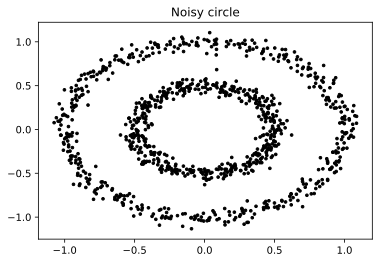

In [13]:
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
points_noisy_circles=noisy_circles[0]

f1=points_noisy_circles[0:((n_samples)), 0]
f2=points_noisy_circles[0:((n_samples)),1]

plt.scatter(f1, f2, c='black', s=7)
plt.title('Noisy circle')


### 1.B. Noisy moons

Text(0.5, 1.0, 'Noisy moons')

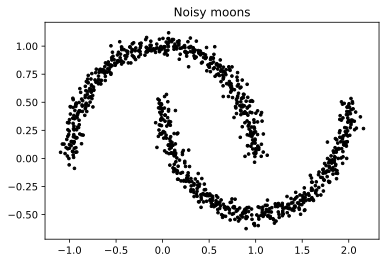

In [14]:
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
points_noisy_moons=noisy_moons[0]
f1=points_noisy_moons[0:((n_samples)), 0]
f2=points_noisy_moons[0:((n_samples)),1]
plt.scatter(f1, f2, c='black', s=7)
plt.title('Noisy moons')

### 1.C. No structure

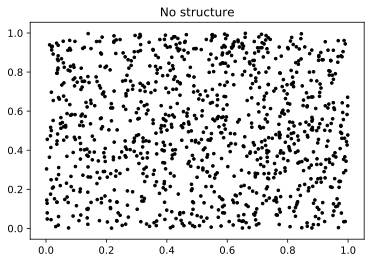

In [15]:
no_structure = np.random.rand(n_samples, 2)
f1=no_structure[0:((n_samples)), 0]
f2=no_structure[0:((n_samples)),1]

plt.title('No structure')
plt.scatter(f1, f2, c='black', s=7) 

### 1.D. Blobs

Text(0.5, 1.0, 'Blobs')

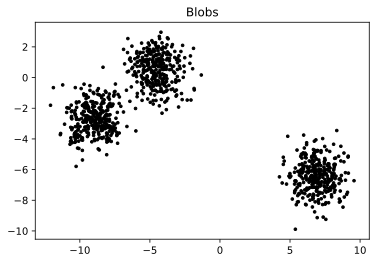

In [16]:
blobs = datasets.make_blobs(n_samples=n_samples, random_state=15)
points_blobs=blobs[0]

f1=points_blobs[0:((n_samples)), 0]
f2=points_blobs[0:((n_samples)),1]

plt.scatter(f1, f2, c='black', s=7)
plt.title('Blobs')

In [17]:
X = np.array(list(zip(f1, f2)))

## 2. Kmeans implementation with Lloyd-Algorithmus

### Pseudo code:

1. **Initialization:** Choose initial centroids or choose k samples from the dataset X

1. Looping between the following steps:
  1. **Assignment:** Each sample is assigned to its nearest center
  2. **Update the centroids:** calculate the mean values of all of the samples assigned to each previous centroid.
  
   the algorithm repeats these last two steps until there is no difference between the old and the new centroids

#### 1. Initialization

1. chossing number of clusers
1.  In order to avoid that no datapoints will be assigned to the initial centroids, we choose some random samples from our dataset

Text(0.5, 1.0, 'Blobs with random centers')

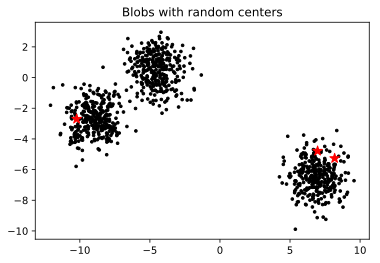

In [18]:
k=3

Indecies_centroid = np.random.choice(n_samples,size=k)     
      
C=X[Indecies_centroid]

plt.scatter(f1,f2,c='black',s=7)
plt.scatter(C[:, 0], C[:, 1],marker='*',c='red',s=100)
plt.title('Blobs with random centers')

#### 2. A. Assignment
1. calculate the distances of every sample to every cluster 
1. select the minimum distance to assign datapoint to the corresponding cluster 

In [19]:
for i in range(len(X)):
            distances = dist(C,[X[i]])

In [20]:
clusters = np.zeros(len(X)) #Generation of an empty array that will be overwritten in for loop 

for i in range(len(X)):
            distances = dist(C,[X[i]])
            cluster = np.argmin(distances)
            clusters[i] = cluster

#### 2.B. Update
1. calculate the mean values of all of the samples assigned to each previous centroid
1. repeat the last two steps (assignment and update) until the centroids don't change anymore (distance between C_old and C(new) equals 0)
1. apply algorithm on blob dataset

In [21]:
for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
        
print(C)

[[ 7.72885967 -6.77356679]
 [-6.7472807  -1.09022621]
 [ 6.2138322  -6.12885892]]


In [22]:
clusters = np.zeros(len(X))
C_old = np.zeros(C.shape)
update_centroids = dist(C, C_old) # Konvergenz

while update_centroids.all() != 0:
    for i in range(len(X)):
            distances = dist(C,[X[i]])
            cluster = np.argmin(distances)
            clusters[i] = cluster
    C_old = deepcopy(C) # der alte Wert muss zwischengespeichert werden, damit Veränderung von C_od zu C (new) berrechnet werden kann
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    update_centroids = dist(C, C_old)

Text(0.5, 1.0, 'Blobs clustered with kmeans')

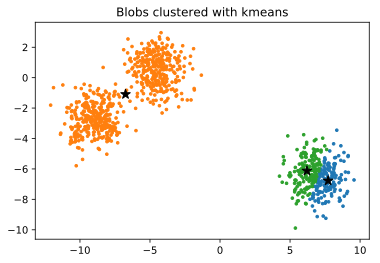

In [23]:
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7)
ax.scatter(C[:, 0], C[:, 1], marker='*', c='black', s=100)
plt.title('Blobs clustered with kmeans')

## 3. K-means ++ implementation

### Pseudo code:

   1. Chose one center C2 uniformly at random X
   2. Chose new center Ci with x e X with probability Dx^2/(summe Dx^2)
   3. Repeat step 2 until we reach the number of k centers altogether
   4. Proceed as with the standard k-means algorthm
   1. apply algorithm on blob dataset

#### 1. Take one center c1, chosen uniformly at random from X

In [24]:
C2 = np.random.random((1,2))
print(C2)

[[0.32632503 0.30673217]]


####    2./3.  Chose new center Ci

with x e X with probability Dx^2/(summe Dx^2)
D(x) denotes the shortest distance from a data point to the closest center we have already chosen

Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)2

**Preparation**

In [25]:
# distance calculator

def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

#"Kmeans part"    
clusters = np.zeros(len(X))
C_old = np.zeros(C2.shape)
error = dist(C2, C_old) # convergence

#"Kmeans++ part"
data_2 = pd.DataFrame(X)
data_long = data_2.reset_index().melt(id_vars="index") #add index from probability distribution to data 
a = np.array(data_long)
index =a[0:n_samples,0] #define index
Liste =[] #list for minimal distances

In [26]:
print(C2)

[[0.32632503 0.30673217]]


In [27]:
k=3 #define number of clusters 

In [28]:
n=0

while n < k - 1:
    n=n+1
    Liste =[]
    for i in range (len(X)):
        diff=X[i]-C2
        dist = np.linalg.norm(diff,axis=1) # calculate the distance 
        min_dist= np.min(dist)
        Liste.append(min_dist)
    s= np.array(Liste)
    dist_2 = (s)**2
    prob = (dist_2)/ sum (dist_2) #p-distribution
    z=np.random.choice(index, p=prob) #add index of new cluster to data 
    c_neu=X[z] #define datapoint with index z as new center 
    cl = np.ndarray.tolist(C2) #convert old array to list to be able to add new values
    c_neul = np.ndarray.tolist (c_neu) #convert new value to list 
    cl.append (c_neul) # add new centers to center list 
    C2 = np.array(cl) #convert list to array
print(C2)

[[ 0.32632503  0.30673217]
 [-8.19135148 -3.32727789]
 [ 7.96784358 -6.22983873]]


Text(0.5, 1.0, 'Blobs with centers defined by kmeans++ algorithm')

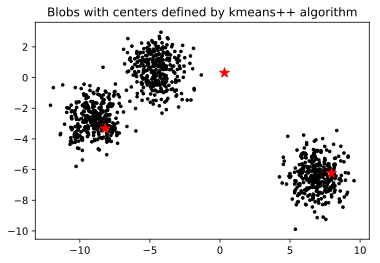

In [29]:
cx1= C2[0:((k)),0]
cy1 = C2[0:((k)),1]

plt.scatter(f1,f2,c='black',s=7)

plt.scatter(cx1,cy1,marker='*',c='red',s=100)
plt.title('Blobs with centers defined by kmeans++ algorithm')

In [30]:
while error.all() != 0:
    for i in range(len(X)):
            diff2=X[i]-C2
            distances = np.linalg.norm(diff2,axis=1) # calculate the distance 
            cluster = np.argmin(distances)
            clusters[i] = cluster
    C_old = deepcopy(C2)
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C2[i] = np.mean(points, axis=0)
    diff3 = C2-C_old
    error = np.linalg.norm(diff3,axis=1) # calculate the distance

Text(0.5, 1.0, 'Blobs clustered with kmeans++')

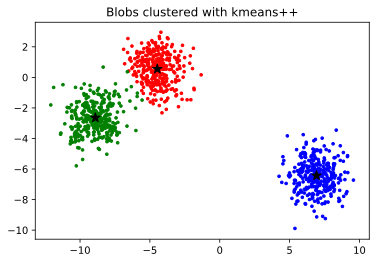

In [31]:
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
plt.scatter(cx1,cy1,marker='*',c='black',s=100)
plt.title('Blobs clustered with kmeans++')

## 4. Mini-batch implementation

In [32]:
a = np.array(list(zip(f1, f2)))

### 1. build minibatches

In [33]:
start1 = time.time()
numrows = np.size(a, 0)
numcols = np.size(a, 1)
end1 = time.time()

In [34]:

batch_s = 100
i = 0
neurows = numrows

# in order to be able to create a batch generator matrix, length of the data (numrows) is reduced accordingly

while (numrows / batch_s) != (numrows // batch_s):
    numrows = numrows - i
    i += 1
print(numrows)
print(numrows / batch_s)


1000
10.0


In [35]:
# batch generator matrix = batches

batches = np.arange(numrows).reshape(batch_s, (numrows // batch_s))
a[batches[0]]

array([[ -8.43157429,  -3.27859587],
       [  7.3435412 ,  -6.50409389],
       [-11.22211103,  -0.48031088],
       [ -8.75787547,  -0.85608018],
       [ -2.69755772,  -1.43889928],
       [ -7.85183284,  -3.31344217],
       [ -8.95653589,  -4.02758281],
       [  6.77928432,  -6.14557786],
       [ -7.62518047,  -3.3706649 ],
       [ -5.06161773,   1.82390755]])

### 2. Centroid initiation

[[[-10.13892931   6.9770168 ]]

 [[ -1.93947711  -6.73524235]]]


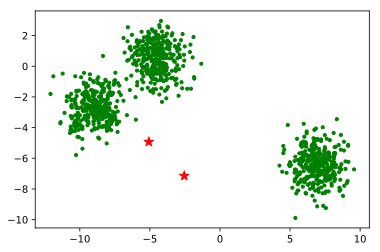

In [36]:
f1= a[:, 0]
f2= a[:, 1]

plt.scatter(f1, f2, c='green', s=10)

X_mini = (list(zip(f1, f2)))

k=2
c1 = np.random.choice(f1, size=k)
c2 = np.random.choice(f2, size=k)

plt.scatter(c1, c2, marker='*',c='red',s=100)

centroid_array = np.array([[np.random.choice(f1, size=k)], 
                           [np.random.choice(f2, size=k)]])

print (centroid_array)

In [37]:
def dist(cell_loc, cluster_number):

    return np.linalg.norm(a[cell_loc, :] - centroid_array[cluster_number - 1, :])

def assign_centroids(a_array):
    global nearest_centroid
    z = 0
    nearest_centroid = np.zeros([numrows, 1])
    
    # Loop over all datapoints
    while z < numrows:
        sml_distance = -1

        # Loop over every centroid
        j = 1
        while j <= k:

            if sml_distance == -1 or dist(z, j) < sml_distance:
                sml_distance = dist(z, j)
                nearest_centroid[z, 0] = j
            j += 1
        z += 1

In [38]:
n_iterations = (numrows // batch_s)
v = np.zeros((k, 1))
j = 1
ctrnew = centroid_array
while (j <= n_iterations):
    
        batch = (a[batches[j-1]]) # implementation of j-1 batches with the help of batch_generator matrix
        
        assign_centroids(batch)
        z = 0
        
        while (z < batch_s):
            c = ctrnew[int(nearest_centroid[z, 0])-1, :]
            v[int((nearest_centroid[z, 0]-1)), 0] =  int(v[int((nearest_centroid[z, 0]-1)), 0]) + 1
            n = 1/v[int((nearest_centroid[z, 0]-1)), 0]
            ctrnew[int(nearest_centroid[z, 0])-1, :] = c * (1-n) + a[z, :] * n
            z+=1
        j+=1
        
centroid_array = ctrnew
assign_centroids(a)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))

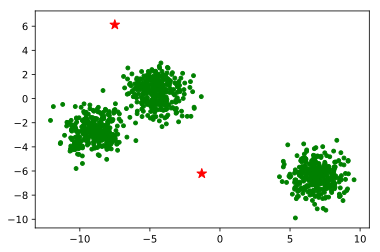

In [39]:

plt.scatter(f1, f2, c='green', s=15)

X_mini = (list(zip(f1, f2)))

plt.scatter(ctrnew[0,:],ctrnew[1,:], marker='*',c='red',s=100)

## 5.comparison
### 5.A. Scikit - learn implementations
Here we only compared the Kmeans algorithms to show the comparing algorithm. THe comparison of the other algorithms will be shown in the presentation.

**1. Kmeans**

Text(0.5, 1.0, 'Blobs clustered with scitlearn kmeans')

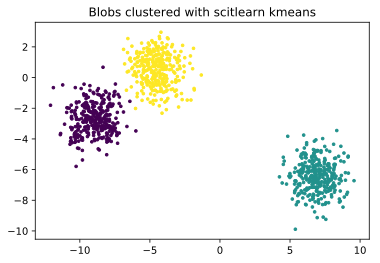

In [40]:
kmeans = KMeans(n_clusters=3).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=kmeans,s=7)
plt.title('Blobs clustered with scitlearn kmeans')

**2. Kmeans++**

Text(0.5, 1.0, 'Blobs clustered with scitlearn kmeans++')

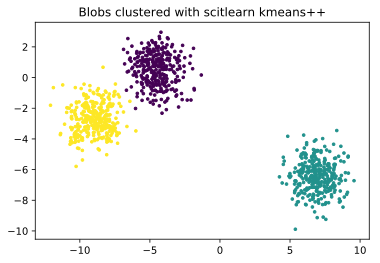

In [41]:
kmeans = KMeans(n_clusters=3,init='k-means++').fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=kmeans,s=7)
plt.title('Blobs clustered with scitlearn kmeans++')

**3. Minibatch**

In [42]:
k=3
batch_s=100
kmeans = MiniBatchKMeans(n_clusters=k, 
                         random_state=0, 
                         batch_size=batch_s)
i = 0

while (i < n_iterations):
    kmeans = kmeans.partial_fit(a[(0 + batch_s * i):(batch_s + batch_s * i),:])
    i+=1

kmeans.cluster_centers_   


array([[ 6.92598584, -6.43191022],
       [-8.97315628, -2.68802711],
       [-4.52140512,  0.50757468]])

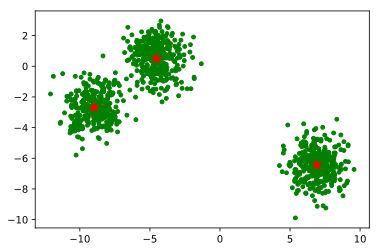

In [43]:

plt.scatter(f1, f2, c='green', s=15)

X = (list(zip(f1, f2)))

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1] , marker='*',c='red',s=100)

## 1. Quality


In [44]:
X = np.array(list(zip(f1, f2)))

def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

*Own implementation*

In [45]:
k_all=(2,3,5) # hier kann man die Anzahl an k, die man vergleichen will, einfach eingeben

WSS_own = np.zeros(len(k_all))

for l in range(len(k_all)):
    k=k_all[l]
    
    times_to_repeat = 10

    sum_WSS = 0
    
    
    for j in range (times_to_repeat):


        start_time = timeit.default_timer()


        Indecies_centroid = np.random.choice(n_samples,size=k) # for initialization we choose some random datapoint in order to avoid that no data points were assigned to random centroid


        C=X[Indecies_centroid]

        clusters = np.zeros(len(X))
        C_old = np.zeros(C.shape)
        error = dist(C, C_old) # Konvergenz
        from copy import deepcopy

        while error.all() != 0:
            for i in range(len(X)):
                    distances = dist(C,[X[i]])
                    cluster = np.argmin(distances)
                    clusters[i] = cluster
            C_old = deepcopy(C)
            for i in range(k):
                points = [X[j] for j in range(len(X)) if clusters[j] == i]
                C[i] = np.mean(points, axis=0)
            error = dist(C, C_old)


        
        WSS=0

        for j in range(len(X)):
        
            WSS += dist(X[j],C[int(clusters[j])], ax = 0)**2
  
        sum_WSS=sum_WSS+WSS
    
    average_WSS= (sum_WSS/times_to_repeat)
    
      
    
    WSS_own[l]=average_WSS
   
    print(WSS_own)
        

[7005.74441489    0.            0.        ]
[7005.74441489 3993.59225642    0.        ]
[7005.74441489 3993.59225642 2118.34466536]


*Scitlearn implementation*

In [46]:
n_clusters=(2,3,5)

WSS_scikit = np.zeros(len(n_clusters))

for l in range(len(n_clusters)):

    times_to_repeat = 10

    sum_WSS = 0

    for i in range (times_to_repeat):
        
        

        start_time = timeit.default_timer()

        kmeans = KMeans(n_clusters[l])


        a = kmeans.fit_predict(X)
        kmeans.inertia_
       
        
        sum_WSS=sum_WSS+kmeans.inertia_
    
        average_WSS= sum_WSS/times_to_repeat
    
        WSS_scikit[l]=average_WSS


print(WSS_scikit)

[7005.74441489 2003.38215145 1530.59846854]


*Plot*

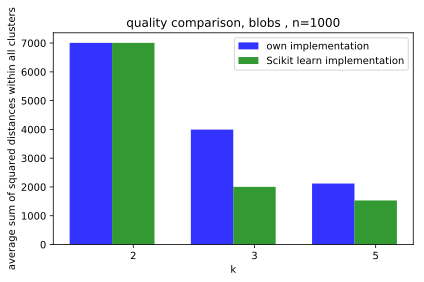

In [47]:
## hab hier alles so angepasst, dass Beschriftungen alle automatisch passen, je nach dem wie man n_samples, k etc verändert hat

# data to plot
n_groups = len(k_all)
means_own = (WSS_own)
means_scikit = (WSS_scikit)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_own, bar_width,
alpha=opacity,
color='b',
label='own implementation')

rects2 = plt.bar(index + bar_width, means_scikit, bar_width,
alpha=opacity,
color='g',
label='Scikit learn implementation')

plt.xlabel('k')
plt.ylabel('average sum of squared distances within all clusters')
plt.title('quality comparison, blobs , n=' +  str(n_samples))
plt.xticks(index + bar_width, (k_all))
plt.legend()

plt.tight_layout()
plt.show()

## 2. Runtime

In [48]:
X = np.array(list(zip(f1, f2)))

def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)


*Own implementation*

In [49]:
k_all=(2,3,5) # hier kann man die Anzahl an k, die man vergleichen will, einfach eingeben

runtime_own = np.zeros(len(k_all))

for l in range(len(k_all)):
    k=k_all[l]
    
    times_to_repeat = 5

    sum_runtime = 0
    
    
    for j in range (times_to_repeat):


        start_time = timeit.default_timer()


        Indecies_centroid = np.random.choice(n_samples,size=k) # for initialization we choose some random datapoint in order to avoid that no data points were assigned to random centroid


        C=X[Indecies_centroid]

        clusters = np.zeros(len(X))
        C_old = np.zeros(C.shape)
        error = dist(C, C_old) # Konvergenz
        from copy import deepcopy

        while error.all() != 0:
            for i in range(len(X)):
                    distances = dist(C,[X[i]])
                    cluster = np.argmin(distances)
                    clusters[i] = cluster
            C_old = deepcopy(C)
            for i in range(k):
                points = [X[j] for j in range(len(X)) if clusters[j] == i]
                C[i] = np.mean(points, axis=0)
            error = dist(C, C_old)


        
        runtime= timeit.default_timer() - start_time
    
        sum_runtime= sum_runtime+runtime
  

    average_runtime= (sum_runtime/times_to_repeat)
    
    
    runtime_own[l]=average_runtime
   
    print(runtime_own)

[0.06111442 0.         0.        ]
[0.06111442 0.04683045 0.        ]
[0.06111442 0.04683045 0.04509494]


*Scitlearn implementation*

In [50]:
n_clusters=(2,3,5)

runtime_scikit = np.zeros(len(n_clusters))

for l in range(len(n_clusters)):
    

    times_to_repeat = 10

    sum_runtime = 0

    for i in range (times_to_repeat):


        start_time = timeit.default_timer()

        kmeans = KMeans(n_clusters[l]).fit_predict(X)


        runtime= timeit.default_timer() - start_time
    
        sum_runtime= sum_runtime+runtime
    
    average_runtime= sum_runtime/times_to_repeat
    
    runtime_scikit[l]=average_runtime
   

print(runtime_scikit)

[0.01063211 0.0135106  0.03579584]


*Plot*

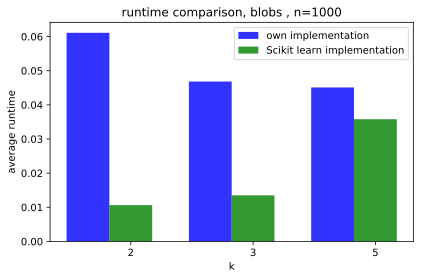

In [51]:
# data to plot
n_groups = len(k_all)
means_own = (runtime_own)
means_scikit = (runtime_scikit)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_own, bar_width,
alpha=opacity,
color='b',
label='own implementation')

rects2 = plt.bar(index + bar_width, means_scikit, bar_width,
alpha=opacity,
color='g',
label='Scikit learn implementation')

plt.xlabel('k')
plt.ylabel('average runtime')
plt.title('runtime comparison, blobs , n=' +  str(n_samples))
plt.xticks(index + bar_width, (k_all))
plt.legend()

plt.tight_layout()
plt.show()

### runtime comparison between kmeans and kmeans ++

In [52]:
k_all=(2,3,5) # hier kann man die Anzahl an k, die man vergleichen will, einfach eingeben

runtime_own = np.zeros(len(k_all))

for l in range(len(k_all)):
    k=k_all[l]
    
    times_to_repeat = 5

    sum_runtime = 0
    
    
    for j in range (times_to_repeat):


        start_time = timeit.default_timer()


        Indecies_centroid = np.random.choice(n_samples,size=k) # for initialization we choose some random datapoint in order to avoid that no data points were assigned to random centroid


        C=X[Indecies_centroid]

        clusters = np.zeros(len(X))
        C_old = np.zeros(C.shape)
        error = dist(C, C_old) # Konvergenz
        from copy import deepcopy

        while error.all() != 0:
            for i in range(len(X)):
                    distances = dist(C,[X[i]])
                    cluster = np.argmin(distances)
                    clusters[i] = cluster
            C_old = deepcopy(C)
            for i in range(k):
                points = [X[j] for j in range(len(X)) if clusters[j] == i]
                C[i] = np.mean(points, axis=0)
            error = dist(C, C_old)


        
        runtime= timeit.default_timer() - start_time
    
        sum_runtime= sum_runtime+runtime
  

    average_runtime= (sum_runtime/times_to_repeat)
    
    
    runtime_own[l]=average_runtime
   
    print(runtime_own)

[0.06462486 0.         0.        ]
[0.06462486 0.04820515 0.        ]
[0.06462486 0.04820515 0.0481174 ]


In [53]:
k_all=(2,3,5) # hier kann man die Anzahl an k, die man vergleichen will, einfach eingeben

runtime_kmplus = np.zeros(len(k_all))

for l in range(len(k_all)):
    k=k_all[l]
    
    times_to_repeat = 5

    sum_runtime = 0
    
    
    for j in range (times_to_repeat):


        start_time = timeit.default_timer()

        C2 = np.random.random((1,2))
        def dist(a, b, ax=1):
            return np.linalg.norm(a - b, axis=ax)

         #"Kmeans part"    
        clusters = np.zeros(len(X))
        C_old = np.zeros(C2.shape)
        error = dist(C2, C_old) # convergence

        #"Kmeans++ part"
        data_2 = pd.DataFrame(X)
        data_long = data_2.reset_index().melt(id_vars="index") #add index from probability distribution to data 
        a = np.array(data_long)
        index =a[0:n_samples,0] #define index
        Liste =[] #list for minimal distances
        k=3
        n=0

        while n < k - 1:
            n=n+1
            Liste =[]
            for i in range (len(X)):
                diff=X[i]-C2
                dist = np.linalg.norm(diff,axis=1) # calculate the distance 
                min_dist= np.min(dist)
                Liste.append(min_dist)
            s= np.array(Liste)
            dist_2 = (s)**2
            prob = (dist_2)/ sum (dist_2) #p-distribution
            z=np.random.choice(index, p=prob) #add index of new cluster to data 
            c_neu=X[z] #define datapoint with index z as new center 
            cl = np.ndarray.tolist(C2) #convert old array to list to be able to add new values
            c_neul = np.ndarray.tolist (c_neu) #convert new value to list 
            cl.append (c_neul) # add new centers to center list 
            C2 = np.array(cl) #convert list to array

        runtime= timeit.default_timer() - start_time
    
        sum_runtime= sum_runtime+runtime
  

    average_runtime= (sum_runtime/times_to_repeat)
    
    
    runtime_kmplus[l]=average_runtime
   
    print(runtime_kmplus)



[0.02975519 0.         0.        ]
[0.02975519 0.03652567 0.        ]
[0.02975519 0.03652567 0.02911179]


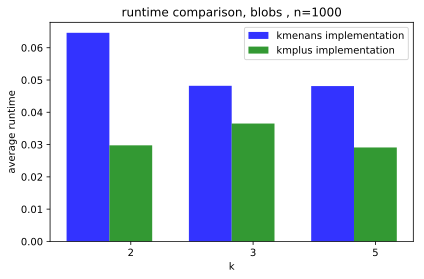

In [54]:
# data to plot
n_groups = len(k_all)
means_own = (runtime_own)
means_kmplus = (runtime_kmplus)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_own, bar_width,
alpha=opacity,
color='b',
label='kmenans implementation')

rects2 = plt.bar(index + bar_width, means_kmplus, bar_width,
alpha=opacity,
color='g',
label='kmplus implementation')

plt.xlabel('k')
plt.ylabel('average runtime')
plt.title('runtime comparison, blobs , n=' +  str(n_samples))
plt.xticks(index + bar_width, (k_all))
plt.legend()

plt.tight_layout()
plt.show()

## 6. Data cleanup and PCA of 3K PBMCs Dataset

In [55]:
adata = sc.read_10x_mtx(
    'C:/Users/Computer/Desktop/pbmc3k_filtered_gene_bc_matrices.tar/pbmc3k_filtered_gene_bc_matrices/hg19',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)   

x = adata._X.todense()
x.shape #shape of the data

(2700, 32738)

### Data cleanup
#### 1. Basic Filtering:
1. Filter out the cells that express less than 200 genes 
1. Filter out genes that are expressed in less than 3 cells
1. Normalize and logarithmize the data

#### 2. mitochondrial DNA:

the value of the ratio of mitochondrial DNA and cellular RNA shows how high or low the quality of a cell is. The higher the proportion of mtDNA, the lower the quality of the data. From a biological point of view, more mitochondrial DNA shows that from a e.g. damaged cell, more "normal" RNA could be lost through perforations, while the larger mtDNA stays in the cell.

   1. calculate the ratio of mtDNA and RNA
   1. filter out cells with too high percentages


In [56]:
sc.pp.filter_cells(adata,min_genes=200)#filter cells with minimum 200 expressed genes
sc.pp.filter_genes(adata,min_cells=3) #filter genes with at least 3 cells the genes are expressed in

In [57]:
mtgenes = adata.var_names.str.startswith('MT-')
adata.obs['mito_percent'] = np.sum(adata[:,mtgenes].X, axis = 1).A1/np.sum(adata.X, axis = 1).A1
adata.obs['n_counts']=adata.X.sum(axis=1).A1
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['mito_percent'] < 0.05, :]

In [58]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

In [59]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [60]:
adata = adata[:, adata.var['highly_variable']]

In [61]:
adata.shape

(2638, 1838)

### Principal component analysis
we chose 10 components

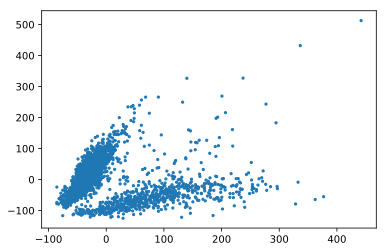

In [62]:
data_array = np.array(x)
pca=PCA(n_components=10)
pca_data=pca.fit_transform(data_array)
pca_data.shape
plt.scatter(pca_data[:,0], pca_data[:,1], s = 5)

### 7. Application of own implementation on dataset
1. Kmeans algorithm 
2. Kmeans ++ algorithm

#### 1. Kmeans algorithm

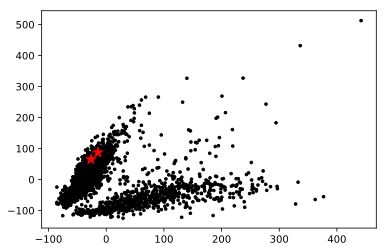

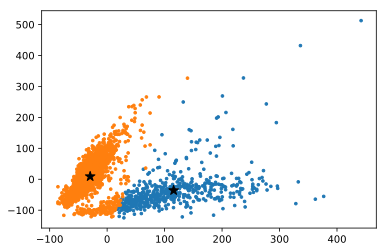

In [63]:
X_data = np.array(pca_data)


def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)


k=2
  
Indecies_centroid = np.random.choice(n_samples,size=k) 
    
C=X_data[Indecies_centroid]

plt.scatter(X_data[:,0],X_data[:,1],c='black',s=7)
plt.scatter(C[:, 0], C[:, 1],marker='*',c='red',s=100)
    
clusters = np.zeros(len(X_data))
C_old = np.zeros(C.shape)
update_centroids = dist(C, C_old) # Konvergenz

while update_centroids.all() != 0:
    for i in range(len(X_data)):
            distances = dist(C,[X_data[i]])
            cluster = np.argmin(distances)
            clusters[i] = cluster
    C_old = deepcopy(C)
    for i in range(k):
        points = [X_data[j] for j in range(len(X_data)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    update_centroids = dist(C, C_old)
        
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X_data[j] for j in range(len(X_data)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7)
ax.scatter(C[:, 0], C[:, 1], marker='*', c='black', s=100)
    


#### 2. Kmeans ++ algorithm 

In [64]:
X_data.shape

(2700, 10)

[[0.77905515 0.49743484 0.80169009 0.25768669 0.34852243 0.41471212
  0.56979756 0.58892529 0.88725532 0.86828863]]


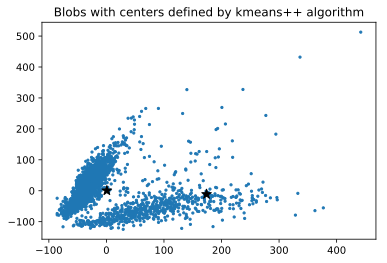

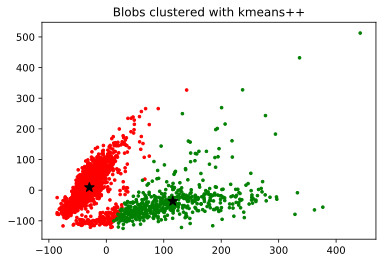

In [65]:
C2 = np.random.random((1,10))
X_data = np.array(pca_data)

print(C2)
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

#"Kmeans part"    
clusters = np.zeros(len(X_data))
C_old = np.zeros(C2.shape)
error = dist(C2, C_old) # convergence

#"Kmeans++ part"
data_2 = pd.DataFrame(X_data)
data_long = data_2.reset_index().melt(id_vars="index") #add index from probability distribution to data 
a = np.array(data_long)
index =a[0:len(X_data),0] #define index
Liste =[] #list for minimal distances
k=2 #define number of clusters 
n=0

while n < k - 1:
    n=n+1
    Liste =[]
    for i in range (len(X_data)):
        diff=X_data[i]-C2
        dist = np.linalg.norm(diff,axis=1) # calculate the distance 
        min_dist= np.min(dist)
        Liste.append(min_dist)
    s= np.array(Liste)
    dist_2 = (s)**2
    prob = (dist_2)/ sum (dist_2) #p-distribution
    z=np.random.choice(index, p=prob) #add index of new cluster to data 
    c_neu=X_data[z] #define datapoint with index z as new center 
    cl = np.ndarray.tolist(C2) #convert old array to list to be able to add new values
    c_neul = np.ndarray.tolist (c_neu) #convert new value to list 
    cl.append (c_neul) # add new centers to center list 
    C2 = np.array(cl) #convert list to array
    
cx1= C2[0:((k)),0]
cy1 = C2[0:((k)),1]


plt.scatter(X_data[:,0], X_data[:,1], s = 5)
plt.scatter(cx1,cy1,marker='*',c='black',s=100)
plt.title('Blobs with centers defined by kmeans++ algorithm')    

while error.all() != 0:
    for i in range(len(X_data)):
            diff2=X_data[i]-C2
            distances = np.linalg.norm(diff2,axis=1) # calculate the distance 
            cluster = np.argmin(distances)
            clusters[i] = cluster
    C_old = deepcopy(C2)
    for i in range(k):
        points = [X_data[j] for j in range(len(X_data)) if clusters[j] == i]
        C2[i] = np.mean(points, axis=0)
    diff3 = C2-C_old
    error = np.linalg.norm(diff3,axis=1) # calculate the distance
    
    

    
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X_data[j] for j in range(len(X_data)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
cx1= C2[0:((k)),0]
cy1 = C2[0:((k)),1]
plt.scatter(cx1,cy1,marker='*',c='black',s=100)
plt.title('Blobs clustered with kmeans++')
C2=[]

### 8. create markergenes dataset


In [66]:
adata = sc.read_10x_mtx(
    'C:/Users/Computer/Desktop/pbmc3k_filtered_gene_bc_matrices.tar/pbmc3k_filtered_gene_bc_matrices/hg19',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)   

x = adata._X.todense()
x.shape #shape of the data

(2700, 32738)

In [67]:
marker_genes = ['IL7R','CCR7','S100A4','GNLY','NKG7','MS4A1','CD8A',
                'FCGR3A','MS4A7','CD14','LYZ','FCER1A','CST3','PPBP']
#create a list with all marker genes

In [68]:
dataframe_total = adata.to_df()


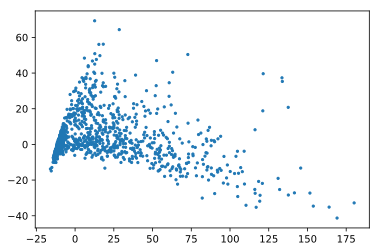

In [69]:
dataframe_markergenes = dataframe_total[marker_genes].copy()
pca=PCA(n_components=14)
pca_markergenes=pca.fit_transform(dataframe_markergenes)
pca_markergenes.shape
plt.scatter(pca_markergenes[:,0], pca_markergenes[:,1], s = 5)
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)
X_marker= np.array(pca_markergenes)

In [70]:
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)
X_marker = np.array(pca_markergenes)


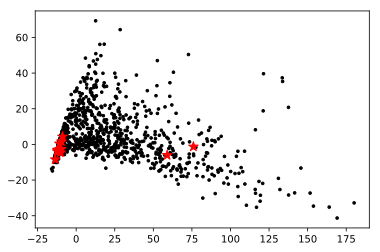

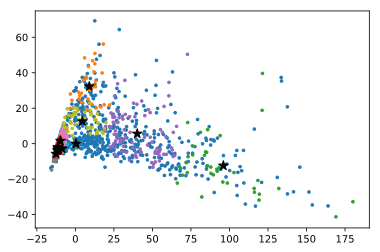

In [71]:
k=14
  
Indecies_centroid = np.random.choice(len(X),size=k) 
    
C=X_marker[Indecies_centroid]

plt.scatter(X_marker[:,0],X_marker[:,1],c='black',s=7)
plt.scatter(C[:, 0], C[:, 1],marker='*',c='red',s=100)
    
clusters = np.zeros(len(X_marker))
C_old = np.zeros(C.shape)
update_centroids = dist(C, C_old) # Konvergenz

while update_centroids.all() != 0:
    for i in range(len(X)):
            distances = dist(C,[X_marker[i]])
            cluster = np.argmin(distances)
            clusters[i] = cluster
    C_old = deepcopy(C)
    for i in range(k):
        points = [X_marker[j] for j in range(len(X_marker)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    update_centroids = dist(C, C_old)
        
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X_marker[j] for j in range(len(X_marker)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7)
ax.scatter(C[:, 0], C[:, 1], marker='*', c='black', s=100)